In [11]:
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns


def image_extraction(filename:str) -> tuple[np.array, pd.DataFrame]:
    """Extract images aswell as the foldless dataset. The indeces will match between ds and image array, but not ID."""
    dataset = h5py.File(filename, 'r')
    ds = pd.DataFrame()
    for i, fold in enumerate(dataset.keys()):
        print(dataset[fold])
        df=pd.DataFrame({'ID':np.array(dataset[fold]['patient_idx']),'target':np.array(dataset[fold]['y']),'diagnosis':np.array(dataset[fold]['diagnosis']),'fold':i})
        ds=pd.concat([ds,df],ignore_index=True,axis=0,keys=['','fold {}'.format(fold)]) # ignore index to match index with image indeces
    #ds.set_index("ID", inplace = True)

    images=np.array(dataset['fold_0']['x']) # Image index corresponds to gen_dataset index, i.e., the ID in the ds
    images = np.append(images,np.array(dataset['fold_1']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_2']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_3']['x']),axis=0)
    images=images.reshape(len(images),800,800)
    dataset.close()
    
    return images, ds


def test_result_extraction(filename,ds):
    """Parameters:
    -----------
    filename : str
        Path to the HDF5 file containing the prediction results.
    ds: pandas.DataFrame
        The original dataframe

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the predicted values, true labels and probabilities for each patient.
        The index of the testset-DataFrame is the ID of the original ds. df.index=ds.ID
    """
    # Open the HDF5 file and extract the necessary data
    f = h5py.File(filename, 'r')
    print('extracting predicted test set')
    pred = np.array(f['predicted'][:])
    patient = np.array(f['patient_idx'][:])
    y = np.array(f['y'][:])
    f.close()

    # Create a DataFrame with the extracted data
    df = pd.DataFrame({'pred':pred.flatten(),'label': y.flatten()},index=patient)

    # Add a column for the predicted probabilities rounded to two decimal places
    df['prob']=np.round(df['pred'],2)

    # Round the predicted values to the nearest integer
    df['pred']=np.round(df['pred'],0)

    test_ds = ds.loc[ds.fold==3.0].sort_values('ID')
    test_ds=test_ds.assign(prob=df.sort_index().prob.values,
               pred=df.sort_index().pred.values)

    return test_ds

       
def check_wrong(df, show_images=True, images=None):
    """
    df: the .h5 file of the test result
    """
    diagnoses=['normal','1, artrose/\nsklerose','2, artrose', '2, mistanke\n MCD',
            '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    wrong=df.iloc[np.where(df['pred'].values!=df['target'])[0]].index

    df['Feilpredikert']= 'Nei'
    df.loc[wrong,('Feilpredikert')] = 'Ja'

    plt.figure()
    confusion_matrix=sklearn.metrics.confusion_matrix(df['target'],df['pred'])
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                                        display_labels = ['normal','abnormal'])
    cm_display.plot()
    plt.title('Confusion matrix with absolute numbers')
    plt.show()

    plt.figure()
    confusion_matrix=sklearn.metrics.confusion_matrix(df['target'],df['pred'], normalize='true')
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                                        display_labels = ['normal','abnormal'])
    cm_display.plot()
    plt.title('Normalisert confusion matrix. (normalisert over sann diagnose)')
    plt.show()

    plt.figure()
    plt.title('Feilklassifiserte prøver')
    sns.histplot(df[df.Feilpredikert=='Ja'], x='prob', bins=100)
    plt.xlabel('Sannsynlighet for abnormalitet')

    plt.figure()
    plt.title('Rett predikerte prøver')
    sns.histplot(df[df.Feilpredikert=='Nei'], x='prob', bins=100)
    plt.xlabel('Sannsynlighet for abnormalitet')

    plt.figure()
    sns.histplot(x='diagnosis',data=df,stat='density',common_norm=True, hue='Feilpredikert',discrete=True,multiple="dodge", shrink=.8) # Bruker originalt datasett for å få alle diagnosene
    plt.xticks(np.arange(8), diagnoses,rotation=45)
    plt.title('Andel av alle predikerte prøver fordelt på hver diagnose')
    plt.ylabel('Andel av alle prøver i testsettet')
    plt.xlabel('Sann diagnose')
    plt.show()

    diagnoses=['normal','1, artrose/sklerose','2, artrose', '2, mistanke MCD',
            '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    if show_images==True:
        for i in wrong:
            print('ID: ',df.ID[i],'\n index: ',i)
            plt.figure()
            plt.imshow(images[i],'gray')
            plt.axis('off')
            plt.title('True: {},\n Predicted probability: {:.2f}'.format(
                                                                    diagnoses[int(df.diagnosis[i])],
                                                                    df.prob[i]))
            plt.show()
                
    df_wrong = df[df.Feilpredikert=='Ja']
    df_wrong = df_wrong.drop(['Feilpredikert'],axis=1)
    return df_wrong

In [2]:
images, ds = image_extraction('//nmbu.no/Research/Project/CubiAI/preprocess/datasets/800_normal_abnormal_2.h5')
df = test_result_extraction('prediction11812132.h5',ds)


<HDF5 group "/fold_0" (4 members)>
<HDF5 group "/fold_1" (4 members)>
<HDF5 group "/fold_2" (4 members)>
<HDF5 group "/fold_3" (4 members)>
extracting predicted test set


<Figure size 640x480 with 0 Axes>

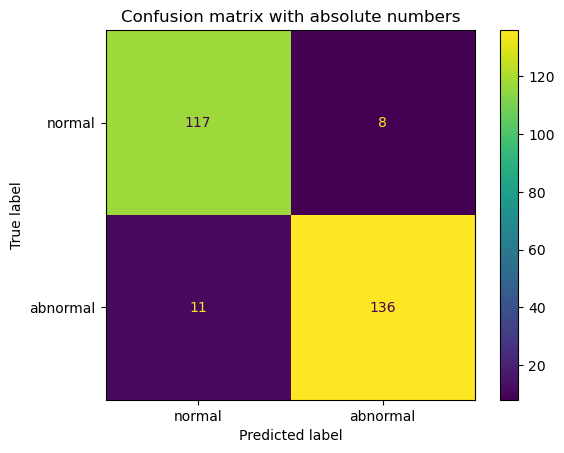

<Figure size 640x480 with 0 Axes>

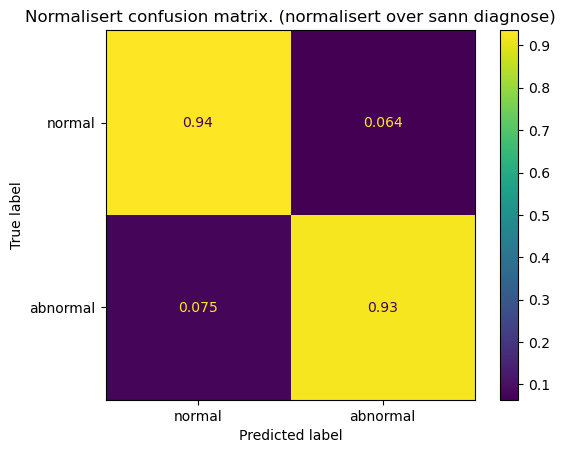

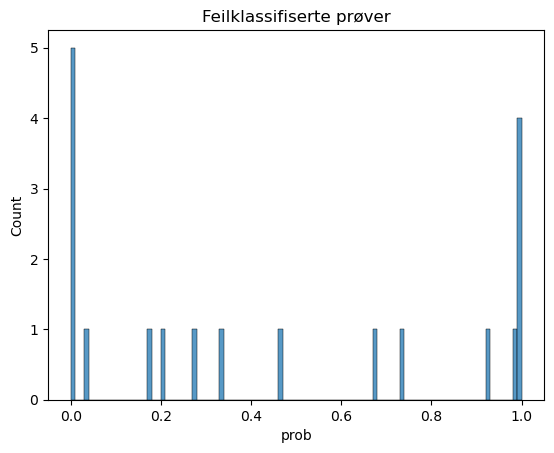

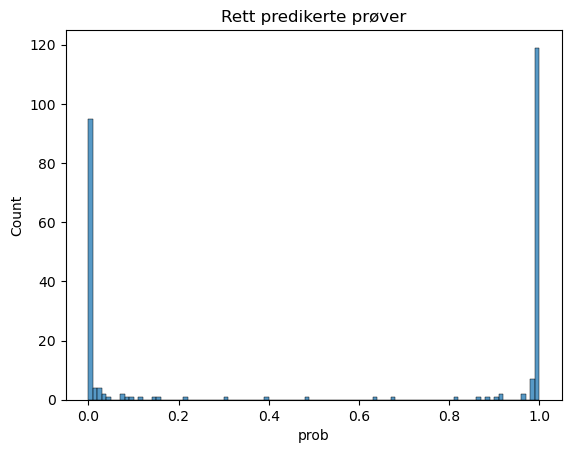

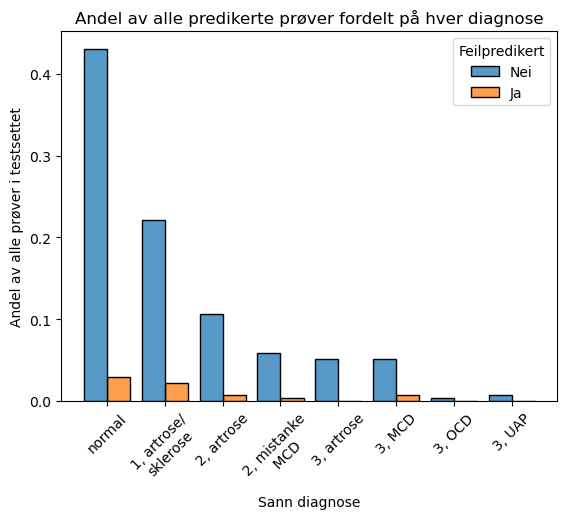

ID:  53.0 
 index:  1080


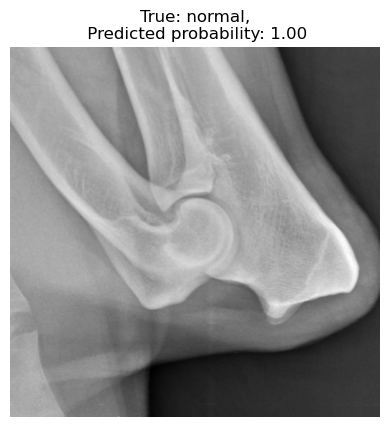

ID:  110.0 
 index:  1079


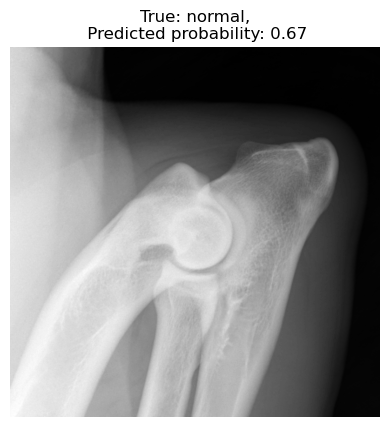

ID:  271.0 
 index:  1051


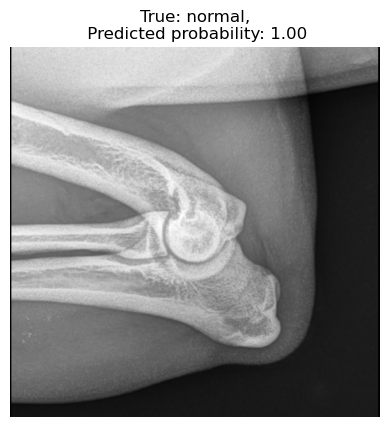

ID:  286.0 
 index:  894


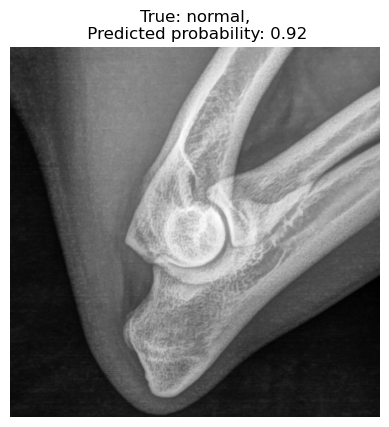

ID:  313.0 
 index:  885


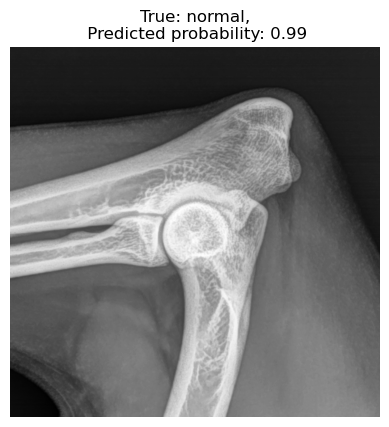

ID:  408.0 
 index:  1038


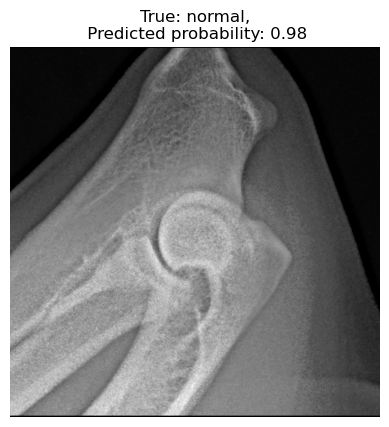

ID:  430.0 
 index:  1008


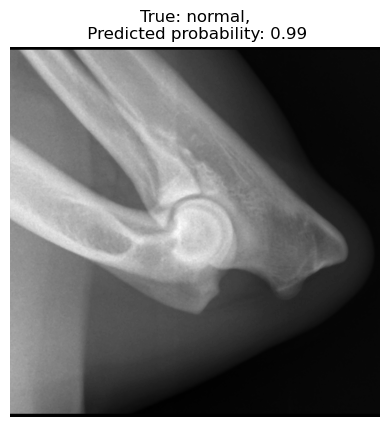

ID:  481.0 
 index:  1035


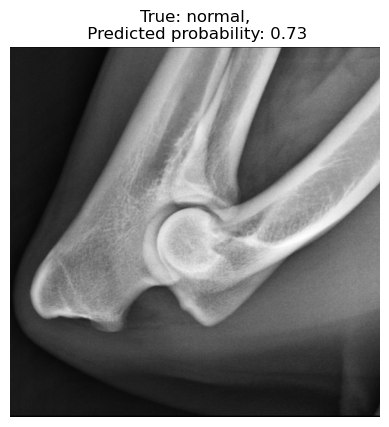

ID:  514.0 
 index:  1062


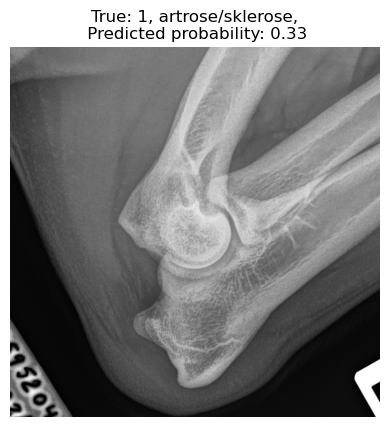

ID:  656.0 
 index:  932


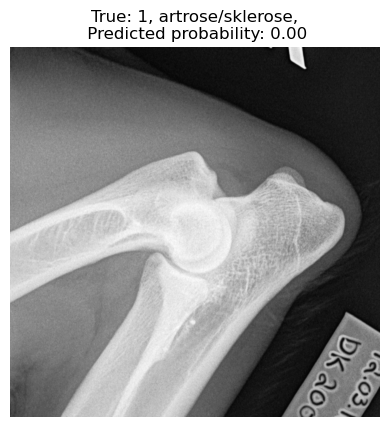

ID:  659.0 
 index:  1030


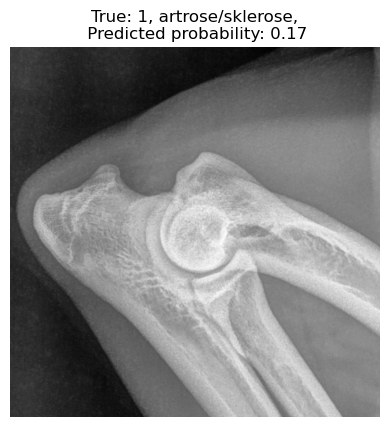

ID:  677.0 
 index:  1025


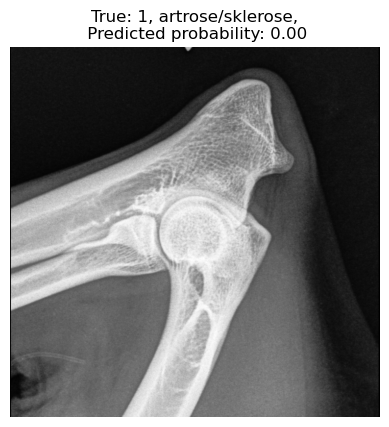

ID:  741.0 
 index:  1071


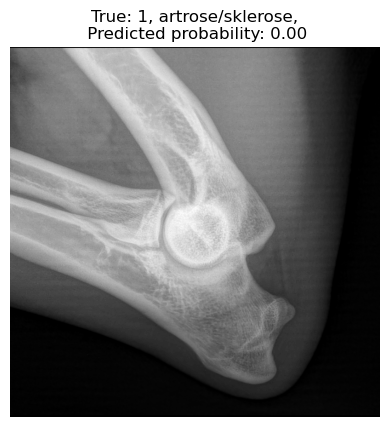

ID:  749.0 
 index:  973


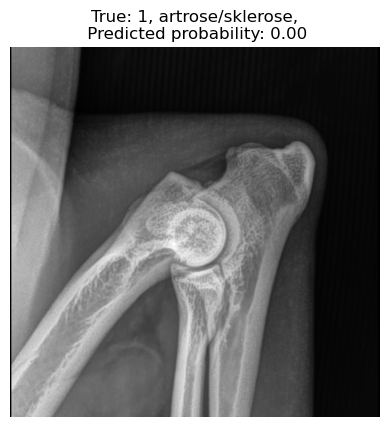

ID:  790.0 
 index:  986


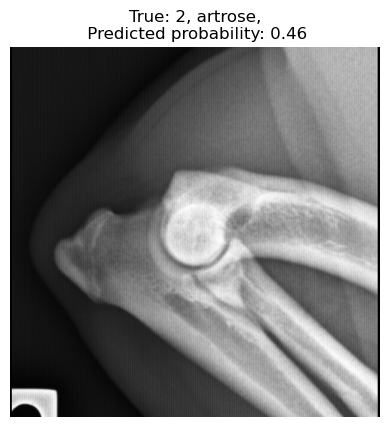

ID:  861.0 
 index:  993


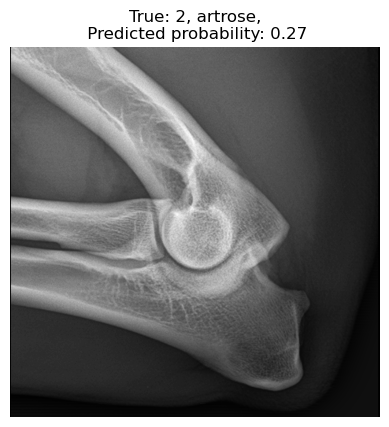

ID:  924.0 
 index:  832


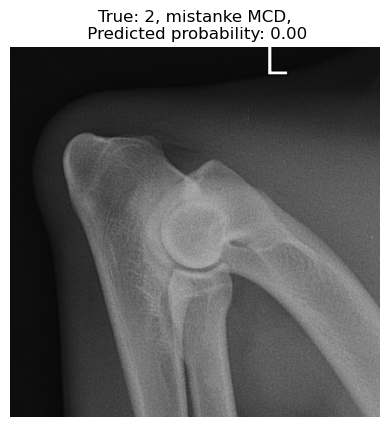

ID:  1017.0 
 index:  930


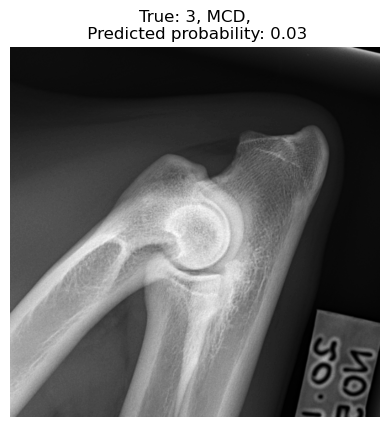

ID:  1040.0 
 index:  1075


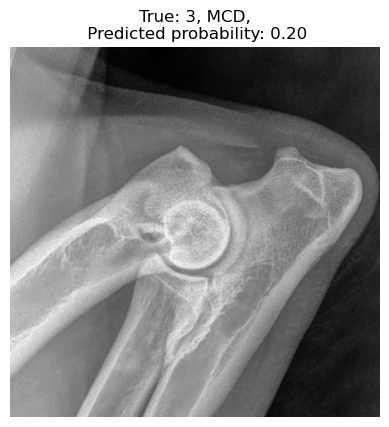

In [12]:
df_wrong=check_wrong(df,True,images)

Fetching all datasets of test data and making one dataframe of all of them, then closing the file.